In [1]:
import bz2
import os

from urllib.request import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)

In [2]:
from model import create_model
nn4_small2 = create_model()

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
dim is deprecated, use axis instead


In [ ]:
nn4_small2.summary()

In [3]:

from keras import backend as K
from keras.models import Model
from keras.layers import Input,Layer

in_a = Input(shape=(96,96,3))
in_p = Input(shape=(96,96,3))
in_n = Input(shape=(96,96,3))

emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

In [ ]:
from data import triplet_generator

# triplet_generator() creates a generator that continuously returns 
# ([a_batch, p_batch, n_batch], None) tuples where a_batch, p_batch 
# and n_batch are batches of anchor, positive and negative RGB images 
# each having a shape of (batch_size, 96, 96, 3).
generator = triplet_generator() 

nn4_small2_train.compile(loss=None, optimizer='adam')
nn4_small2_train.fit_generator(generator, epochs=10, steps_per_epoch=100)

# Please note that the current implementation of the generator only generates 
# random image data. The main goal of this code snippet is to demonstrate 
# the general setup for model training. In the following, we will anyway 
# use a pre-trained model so we don't need a generator here that operates 
# on real training data. I'll maybe provide a fully functional generator
# later.

In [4]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('weights/nn4.small2.v1.h5')

In [12]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, file):
        # dataset base directory
        self.base = base
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        ext = os.path.splitext(i)[1]
        metadata.append(IdentityMetadata(path, i))
    return np.array(metadata)

metadata_test_faces = load_metadata('test_faces')
metadata_test_gan_sample = load_metadata('test_gan_sample')
metadata_test_gan_sample_1 = load_metadata('test_gan_sample_1')
metadata_test_vae_sample = load_metadata('test_vae_sample')

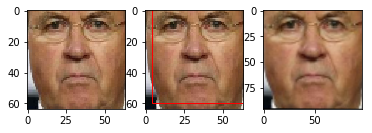

In [15]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('models/landmarks.dat')

# Load an image of Jacques Chirac
jc_orig = load_image(metadata_test_faces[100].image_path())

# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(jc_orig)

# Transform image using specified face landmark indices and crop image to 96x96
jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# Show original image
plt.subplot(131)
plt.imshow(jc_orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(jc_aligned);

In [16]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [37]:
embedded_test_faces = np.zeros((metadata_test_faces.shape[0], 128))
embedded_test_gan_sample = np.zeros((metadata_test_gan_sample.shape[0], 128))
embedded_test_gan_sample_1 = np.zeros((metadata_test_gan_sample_1.shape[0], 128))
embedded_test_vae_sample = np.zeros((metadata_test_vae_sample.shape[0], 128))
corrupt = []
gan_path = 'test_gan_sample'
gan_1_path = 'test_gan_sample_1'
vae_path = 'test_vae_sample'
for i, m in enumerate(metadata_test_vae_sample):
    m1=str(m)
    file = m1.split('/')
    test_img = load_image(m.image_path())
    gan_img = load_image(os.path.join(gan_path,file[1]))
    gan_1_img = load_image(os.path.join(gan_1_path,file[1]))
    vae_img = load_image(os.path.join(vae_path,file[1]))
    test_img = align_image(test_img)
    gan_img = align_image(gan_img)
    gan_1_img = align_image(gan_1_img)
    vae_img = align_image(vae_img)
    if test_img is not None and gan_img is not None and gan_1_img is not None and vae_img is not None:
        # scale RGB values to interval [0,1]
        test_img = (test_img / 255.).astype(np.float32)
        gan_img = (gan_img / 255.).astype(np.float32)
        gan_1_img = (gan_1_img / 255.).astype(np.float32)
        vae_img = (vae_img / 255.).astype(np.float32)
    # obtain embedding vector for image
    try:
        embedded_test_faces[i] = nn4_small2_pretrained.predict(np.expand_dims(test_img, axis=0))[0]
        embedded_test_gan_sample[i] = nn4_small2_pretrained.predict(np.expand_dims(gan_img, axis=0))[0]
        embedded_test_gan_sample_1[i] = nn4_small2_pretrained.predict(np.expand_dims(gan_1_img, axis=0))[0]
        embedded_test_vae_sample[i] = nn4_small2_pretrained.predict(np.expand_dims(vae_img, axis=0))[0]
    except Exception as e:
        corrupt.append(i)
        


640

In [38]:
embedded_test_faces = np.delete(embedded_test_faces,corrupt,0)
embedded_test_gan_sample = np.delete(embedded_test_gan_sample,corrupt,0)
embedded_test_gan_sample_1 = np.delete(embedded_test_gan_sample_1,corrupt,0)
embedded_test_vae_sample = np.delete(embedded_test_vae_sample,corrupt,0)

In [40]:
metadata_test_faces = np.delete(metadata_test_faces,corrupt,0)
metadata_test_gan_sample = np.delete(metadata_test_gan_sample,corrupt,0)
metadata_test_gan_sample_1 = np.delete(metadata_test_gan_sample_1,corrupt,0)
metadata_test_vae_sample = np.delete(metadata_test_vae_sample,corrupt,0)

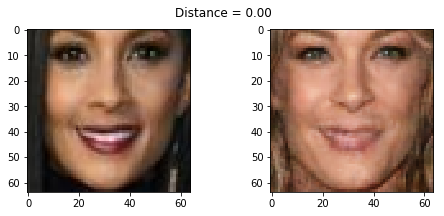

In [82]:
def  distance (emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embedded_test_faces[idx1], embedded_test_vae_sample[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata_test_faces[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata_test_vae_sample[idx2].image_path()));    

show_pair(9, 9)

In [83]:
embedded_test_vae_sample[0]

array([ 0.13634349, -0.10964461, -0.10897512,  0.03537494,  0.10171776,
        0.10509412,  0.02251883,  0.02309688, -0.0155589 , -0.29733384,
       -0.05413716,  0.10824153, -0.00827198, -0.12989186, -0.10219123,
       -0.07481896, -0.10025322, -0.03883748, -0.04432345,  0.06658565,
        0.10635655,  0.09857605,  0.09480106,  0.04883419,  0.00290854,
       -0.17463036,  0.04699966, -0.13639565, -0.1317808 ,  0.10720247,
       -0.02713799, -0.12716024, -0.0191864 ,  0.04296836,  0.01374512,
       -0.07359951, -0.05069616, -0.16419943, -0.10789239,  0.00780779,
        0.06191407, -0.00602461,  0.01621921,  0.1480367 , -0.14288461,
        0.00964869,  0.04233558, -0.03241861,  0.02484615,  0.21747185,
        0.00214952, -0.10112918,  0.09579088,  0.02959117,  0.00875103,
       -0.0696384 ,  0.03434094,  0.03577636, -0.02757909,  0.01849871,
        0.01387626,  0.076274  ,  0.05805276, -0.00243115, -0.04732378,
       -0.23593338,  0.00257007, -0.06816646, -0.01860312, -0.03

In [ ]:
embedded_test_f[0]

In [75]:
np.mean(vae_distances)

0.0

In [72]:
gan_distances = []
gan_1_distances = []
vae_distances = []

num = 433

for i in range(num - 2):
    gan_distances.append(distance(embedded_test_faces[i], embedded_test_gan_sample[i]))
    gan_1_distances.append(distance(embedded_test_faces[i], embedded_test_gan_sample_1[i]))
    vae_distances.append(distance(embedded_test_faces[i], embedded_test_vae_sample[i]))                

In [81]:
correct_gan=0
correct_gan_1=0
correct_vae=0

for i in range(431):
    if(gan_distances[i]<=0.77):
        correct_gan+=1
    if(gan_1_distances[i]<=0.77):
        correct_gan_1+=1
    if(vae_distances[i]<=0.77):
        correct_vae+=1    
        
print("Accuracy for CGAN",(correct_gan/431)*100,"%")
print("Accuracy for RCGAN",(correct_gan_1/431)*100,"%")
print("Accuracy for VAE",(correct_vae/431)*100,"%")

Accuracy for CGAN 70.30162412993039 %
Accuracy for RCGAN 85.38283062645012 %
Accuracy for VAE 100.0 %
